In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # [PERBAIKAN] Tambahkan SMOTE
import pickle

In [2]:
# 1. Membaca Data
file_path = 'fruit.xlsx'  # Sesuaikan path jika perlu
data = pd.read_excel(file_path)

In [3]:
# 2. Informasi Data
print("DataFrame Info:")
data.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   diameter  10000 non-null  float64
 1   weight    10000 non-null  float64
 2   red       10000 non-null  int64  
 3   green     10000 non-null  int64  
 4   blue      10000 non-null  int64  
 5   name      10000 non-null  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [4]:
print("\nDeskripsi Data:")
print(data.describe())


Deskripsi Data:
           diameter        weight           red         green          blue
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       9.975685    175.050792    153.847800     76.010600     11.363200
std        1.947844     29.212119     10.432954     11.708433      9.061275
min        2.960000     86.760000    115.000000     31.000000      2.000000
25%        8.460000    152.220000    147.000000     68.000000      2.000000
50%        9.980000    174.985000    154.000000     76.000000     10.000000
75%       11.480000    197.722500    161.000000     84.000000     17.000000
max       16.450000    261.510000    192.000000    116.000000     56.000000


In [5]:
# Memeriksa missing values
if data.isnull().sum().sum() > 0:
    print("Terdapat missing values, silakan bersihkan data terlebih dahulu.")
else:
    print("Tidak ada missi")

Tidak ada missi


In [6]:
# 3. Preprocessing Data
x = data.drop(columns=['name'])
y = data['name']

In [7]:
# 4. Encoding Target
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

In [8]:
# # 5. Scaling Fitur
# scaler = StandardScaler()
# x = scaler.fit_transform(x)
# x

In [9]:
# Oversampling dengan SMOTE (jika data tidak seimbang)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x, y)

In [10]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_val = scaler.transform(X_val)          # Only transform on validation data
X_test = scaler.transform(X_test)        # Only transform on test data

In [12]:
# 5. Hyperparameter Tuning (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2']
}

random_forest_model = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(
    estimator=random_forest_model,
    param_grid=param_grid,
    n_jobs=-1,
    verbose=2,
    scoring='f1_weighted',
    cv=5
)

print("Sedang mencari parameter terbaik...")
grid_search.fit(X_train, y_train)

print("\nHasil GridSearch:")
print(f"Skor terbaik: {grid_search.best_score_:.4f}")
print("Parameter terbaik:")
best_params = grid_search.best_params_
for key, value in best_params.items():
    print(f"  - {key}: {value}")

random_forest = grid_search.best_estimator_

Sedang mencari parameter terbaik...
Fitting 5 folds for each of 96 candidates, totalling 480 fits



Hasil GridSearch:
Skor terbaik: 0.9490
Parameter terbaik:
  - bootstrap: True
  - max_depth: 20
  - max_features: sqrt
  - min_samples_leaf: 1
  - min_samples_split: 2
  - n_estimators: 200


In [13]:
# 6. Evaluasi dengan Cross-Validation (Stratified K-Fold) [PERBAIKAN]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # [PERBAIKAN]
cv_scores = cross_val_score(random_forest, x, y, cv=skf, scoring='f1_weighted')  # [PERBAIKAN]
print(f"Rata-rata F1-Score CV (Stratified K-Fold): {cv_scores.mean() * 100:.2f}%")


Rata-rata F1-Score CV (Stratified K-Fold): 95.25%


In [14]:
# 7. Evaluasi pada Data Uji
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       733
           1       0.97      0.95      0.96       767

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500

Akurasi Model: 95.93%


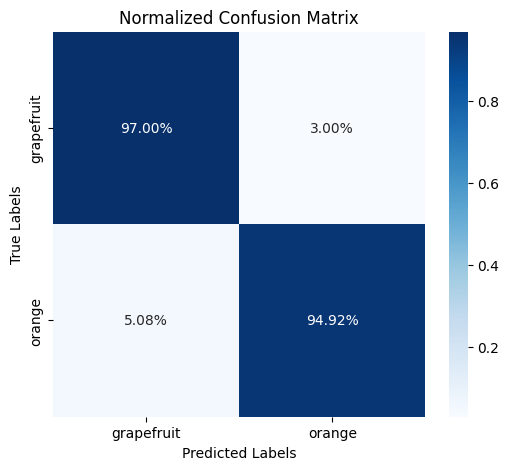

In [15]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm / np.sum(cm, axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues',  # [PERBAIKAN]
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Normalized Confusion Matrix')  # [PERBAIKAN]
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
# 8. Menyimpan Model, Scaler, dan Encoder
with open('grid_search_best_params.pkl', 'wb') as params_file:
    pickle.dump(best_params, params_file)
with open('random_forest_fruit.pkl', 'wb') as model_file:
    pickle.dump(random_forest, model_file)
with open('scaler_fruit_forest.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
with open('label_encoder_fruit_forest.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

print("Model, scaler, dan encoder berhasil disimpan.")

Model, scaler, dan encoder berhasil disimpan.


In [17]:
# Memuat kembali model, scaler, dan encoder menggunakan pickle
with open('random_forest_fruit.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
with open('scaler_fruit_forest.pkl', 'rb') as scaler_file:
    scaler = pickle.load(scaler_file)
with open('label_encoder_fruit_forest.pkl', 'rb') as encoder_file:
    encoder = pickle.load(encoder_file)

In [18]:
def test_new_data(new_data):
    # Validasi kolom
    required_columns = ['diameter', 'weight', 'red', 'green', 'blue']
    if not all(col in new_data.columns for col in required_columns):
        raise ValueError(f"Data baru harus memiliki kolom: {required_columns}")
    
    # Validasi tipe data dan nilai
    if not all(new_data[col].dtype in [np.float64, np.int64] for col in required_columns):
        raise ValueError("Semua kolom harus bertipe numerik (float atau int).")
    if new_data.isnull().any().any():
        raise ValueError("Data baru tidak boleh mengandung nilai NaN.")
    
    # Skala data baru
    new_data_scaled = scaler.transform(new_data)
    # Prediksi
    predictions = random_forest.predict(new_data_scaled)
    return encoder.inverse_transform(predictions)


In [19]:
# Contoh Data Baru
new_data = pd.DataFrame({
    'diameter': [5.5, 6.3],
    'weight': [120, 150],
    'red': [200, 180],
    'green': [50, 60],
    'blue': [30, 40]
})

print("Prediksi untuk data baru:")
try:
    predictions = test_new_data(new_data)
    print(predictions)
except ValueError as e:
    print(f"Error: {e}")

Prediksi untuk data baru:
['orange' 'orange']
